In [6]:
import random
import time
import os
import shutil
import json

from tqdm import tqdm

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt
import itertools

from pytorchCycleGANandpix2pix.models import networks as offnets
from pytorchCycleGANandpix2pix.util.image_pool import ImagePool
from pytorchCycleGANandpix2pix.util.util import tensor2im

import cyclegan_models

import pandas as pd
import seaborn as sns

In [2]:
domain_folders = ["./output/pose_classified_game", "./output/pose_classified_movie"]
class_folders = ["Full Body Sitting", "Full Body Standing", "Half Body", "Head Only", "Other"]
img_file_ext = ".jpg"

In [3]:
def get_class_images(domain_folder, class_folders):
    images = {}
    total = 0
    
    for class_folder in class_folders:
        files = os.listdir(f"{domain_folder}/{class_folder}")
        image_files = [x for x in files if x.endswith(img_file_ext)]
        images[class_folder] = image_files
        total += len(image_files)
        
    return images, total

In [4]:
domain_X_imgs, domain_X_total = get_class_images(domain_folders[0], class_folders)
domain_X_dist = {k: len(domain_X_imgs[k]) / domain_X_total for k in domain_X_imgs.keys()}

In [5]:
domain_Y_imgs, domain_Y_total = get_class_images(domain_folders[1], class_folders)
domain_Y_dist = {k: len(domain_Y_imgs[k]) / domain_Y_total for k in domain_Y_imgs.keys()}

In [8]:
def create_metadata_df(domain_folder, domain_imgs):
    rows = []
    
    for class_name in domain_imgs.keys():
        for image_name in domain_imgs[class_name]:
            row = {
                "file": image_name,
                "pose": class_name
            }
            
            original_loc = f"{domain_folder}/{class_name}/{image_name}"
            image = Image.open(original_loc)
            
            width, height = image.width, image.height
            
            row["width"] = width
            row["height"] = height
            
            rows.append(row)
    
    return pd.DataFrame(rows)

In [9]:
domain_X_metadata = create_metadata_df(domain_folders[0], domain_X_imgs)

In [23]:
domain_Y_metadata = create_metadata_df(domain_folders[1], domain_Y_imgs)

In [24]:
domain_X_metadata

,file,pose,width,height
0,Segmented_Train_Game_01_00004_1.jpg,Full Body Sitting,515,667
1,Segmented_Train_Game_01_00005_1.jpg,Full Body Sitting,515,667
2,Segmented_Train_Game_01_00007_1.jpg,Full Body Sitting,503,664
3,Segmented_Train_Game_01_00120_0.jpg,Full Body Sitting,355,659
4,Segmented_Train_Game_01_00121_0.jpg,Full Body Sitting,355,661
...,...,...,...,...
8651,Segmented_Train_Game_10_00394_2.jpg,Other,463,657
8652,Segmented_Train_Game_10_00395_2.jpg,Other,475,654
8653,Segmented_Train_Game_10_00396_0.jpg,Other,265,551
8654,Segmented_Train_Game_10_00397_0.jpg,Other,255,542


In [25]:
domain_Y_metadata

,file,pose,width,height
0,Segmented_Train_Movie_02_00003_0.jpg,Full Body Sitting,119,303
1,Segmented_Train_Movie_02_00015_3.jpg,Full Body Sitting,121,285
2,Segmented_Train_Movie_02_00526_2.jpg,Full Body Sitting,300,332
3,Segmented_Train_Movie_02_00556_3.jpg,Full Body Sitting,21,84
4,Segmented_Train_Movie_02_00560_2.jpg,Full Body Sitting,36,89
...,...,...,...,...
3952,Segmented_Train_Movie_03_02255_1.jpg,Other,35,105
3953,Segmented_Train_Movie_03_02256_1.jpg,Other,36,106
3954,Segmented_Train_Movie_03_02257_1.jpg,Other,31,79
3955,Segmented_Train_Movie_03_02264_1.jpg,Other,35,56


<Axes: ylabel='Frequency'>

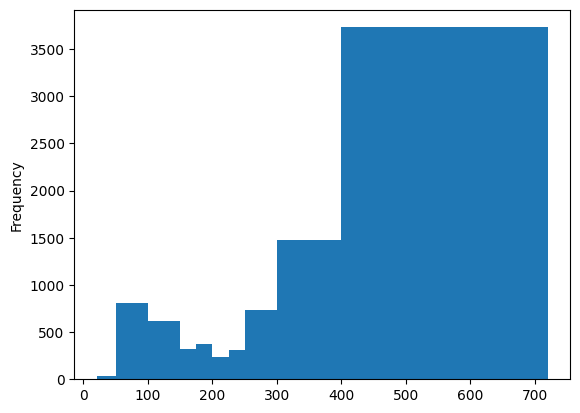

In [60]:
domain_X_min_side = domain_X_metadata[["width", "height"]].min(axis=1)
domain_X_min_side.plot(kind="hist", bins=[domain_X_min_side.min(), 50, 100, 150, 175, 200, 225, 250, 300, 400, 500, 600, domain_X_min_side.max()])

<Axes: ylabel='Frequency'>

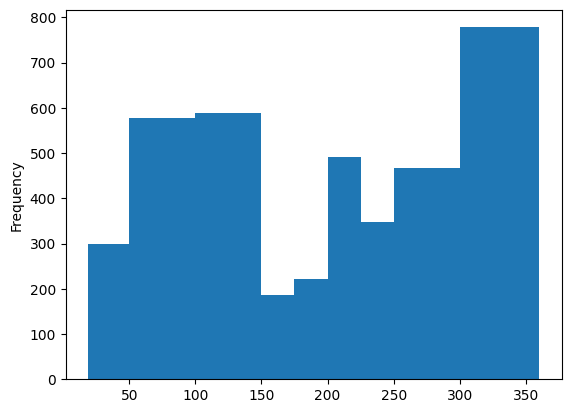

In [65]:
domain_Y_min_side = domain_Y_metadata[["width", "height"]].min(axis=1)
domain_Y_min_side.plot(kind="hist", bins=[domain_Y_min_side.min(), 50, 100, 150, 175, 200, 225, 250, 300, domain_Y_min_side.max()])

<Axes: >

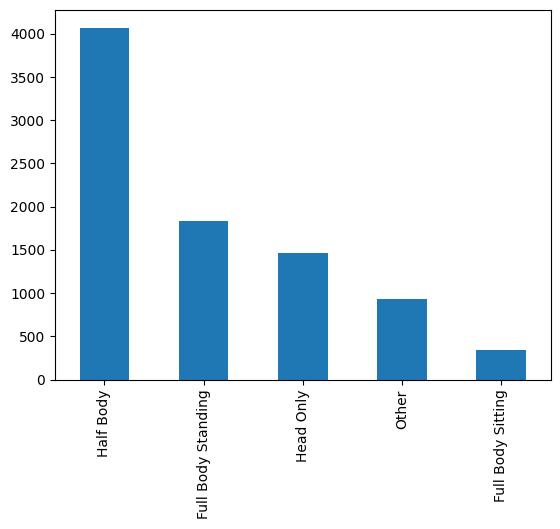

In [44]:
domain_X_metadata["pose"].value_counts().plot(kind="bar")

<Axes: >

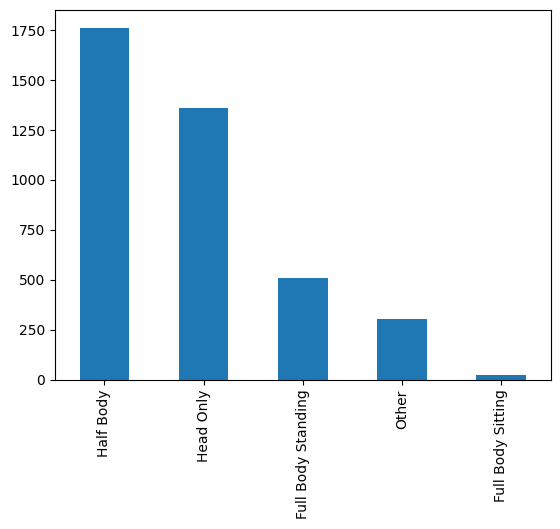

In [48]:
domain_Y_metadata["pose"].value_counts().plot(kind="bar")